In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import warnings
warnings.filterwarnings("ignore")

#import unemployment data
u_data = pd.read_csv(
    "https://github.com/jlcatonjr/COVID19/raw/main/Data/countyUnemploymentData.csv", 
    encoding = "latin1", parse_dates = True).dropna()
# drop observations with missing fips codes
index = u_data["fips_code"].dropna(axis = 0).index
u_data = u_data.loc[index]

u_data["fips_code"] = u_data["fips_code"].astype(int)
u_data = u_data[u_data["fips_code"] < 57000]
u_data["date"] = u_data["date"].str.replace("-", " ")
u_data["date"] = pd.to_datetime(u_data["date"])
u_data.set_index(["date","fips_code"], inplace = True)
to_float =["Labor Force",
           "Employed",
           "Unemployed",
           "Unemployment Rate"]
for key in to_float:
    u_data[key] = u_data[key].str.replace(",","")
    u_data[key] = pd.to_numeric(u_data[key], errors = "coerce")

In [2]:
def import_geo_data(filename, index_col = "Date", FIPS_name = "FIPS"):
    # import county level shapefile
    map_data = gpd.read_file(filename = filename,                                   
                                   index_col = index_col)
    # rename fips code to match variable name in COVID-19 data
    map_data.rename(columns={"State":"state"},
                    inplace = True)
    # Combine statefips and county fips to create a single fips value
    # that identifies each particular county without referencing the 
    # state separately
    map_data[FIPS_name] = map_data["STATEFP"].astype(str) + \
        map_data["COUNTYFP"].astype(str)
    map_data[FIPS_name] = map_data[FIPS_name].astype(np.int64)
    # set FIPS as index
    map_data.set_index(FIPS_name, inplace=True)
    
    return map_data
map_data = import_geo_data(filename = "countiesWithStatesAndPopulation.shp",
    index_col = None, FIPS_name= "fips_code")
dates = u_data.groupby("date").mean().index
counties = u_data.groupby("fips_code").mean().index
u_data["Labor Force as % Population"] = 0

u_data["Population"] = 0
u_data["state"]=""
u_data["Unemployment Rate +/- February 2020"]= 0
for date in dates:
    u_data["state"][u_data.index.get_level_values("date")==date] = map_data[map_data.index.isin(counties)]["state"]   
    u_data["Population"][u_data.index.get_level_values("date")==date] = map_data[map_data.index.isin(counties)]["Population"]
    u_data["Labor Force as % Population"][u_data.index.get_level_values("date")==date] = u_data.loc[date, "Labor Force"].div(map_data[map_data.index.isin(counties)]["Population"]).mul(100)
    u_data["Unemployment Rate +/- February 2020"][u_data.index.get_level_values("date")==date] = u_data.loc[date, "Unemployment Rate"].sub(u_data.loc[datetime.datetime(2020,2,1),"Unemployment Rate" ])

In [3]:
u_data_pivot = pd.pivot_table(u_data.reset_index(), 
               values=['Labor Force', "Employed",
                       "Unemployed", "Unemployment Rate",
                       "Unemployment Rate +/- February 2020",
                       "Labor Force as % Population"], 
               index=['fips_code'], columns=['date'])
u_map_data= map_data[map_data.index.isin(counties)]
for key, val in u_data_pivot.items():
    u_map_data[key] = val

In [4]:
def select_data_within_bounds(data, minx, miny, maxx, maxy):
    data = data[data.bounds["maxx"] <= maxx]
    data = data[data.bounds["maxy"] <= maxy]
    data = data[data.bounds["minx"] >= minx]
    data = data[data.bounds["miny"] >= miny]
    
    return data

date = dates[-1]

if "map_bounded" not in locals():
    minx = u_map_data.bounds["minx"].min()
    miny = u_map_data.bounds["miny"].min()
    maxx = -58
    maxy = u_map_data.bounds["maxy"].max()
    # find counties using only 1 date, only performs operation once instead of 
    # several hundred times
    bounded_data =  select_data_within_bounds(u_map_data, minx, miny, maxx, maxy)
    counties = bounded_data.groupby("fips_code").mean().index
    u_map_data =u_map_data[u_map_data.index.get_level_values("fips_code").isin(counties)]
    map_bounded = True

In [5]:
#Calculate State Level Data

state_df = u_data.reset_index()[["Employed",
                                 "Unemployed",
                                 "Labor Force",
                                "Population",
                                "state",
                                "date"]].copy()

state_df = state_df.groupby(["state", "date"]).sum()
US_df =state_df.groupby("date").sum()
US_df["state"] = "United States"
US_df = US_df.reset_index().set_index(["state", "date"])
state_df = state_df.append(US_df)
state_df["Unemployment Rate"] = state_df["Unemployed"].div(state_df["Labor Force"]).mul(100)
state_df["Labor Force as % Population"] = state_df["Labor Force"].div(state_df["Population"]).mul(100)

state_df["Unemployment Rate +/- February 2020"] = 0
state_df = state_df.reset_index().set_index(["date", "state"])

for date in dates:
    state_df["Unemployment Rate +/- February 2020"][state_df.index.get_level_values("date")==date] =\
        state_df.loc[date, "Unemployment Rate"].sub(state_df.loc[datetime.datetime(2020,2,1),"Unemployment Rate" ])
state_df = state_df.reset_index().set_index(["state", "date"])



state_df_pivot = pd.pivot_table(state_df.reset_index(), 
               values=['Labor Force', "Employed",
                       "Unemployed", "Unemployment Rate", 
                       "Unemployment Rate +/- February 2020",
                       "Labor Force as % Population"], 
               index=['date'], columns=['state'])

In [6]:
state_dict = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ',
    'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 
    'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 
    'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA','Kansas': 'KS', 'Kentucky': 'KY',
    'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI',
    'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX',
    'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'}

interactive(children=(Dropdown(description='date', options=(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

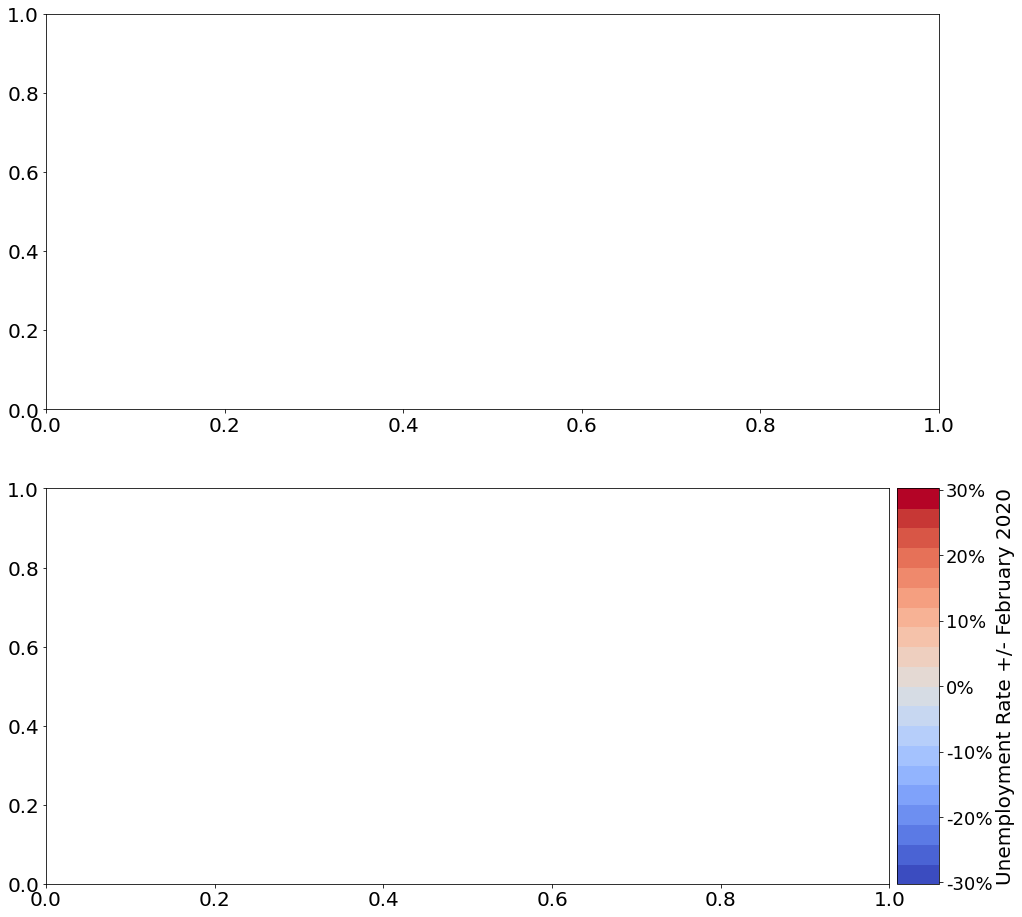

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import *
from ipywidgets.embed import embed_minimal_html
from matplotlib import cm
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.set_option('display.max_rows', None)
plt.rcParams["font.size"] = 20
class geoPlot():
    def __init__(self, map_data, panel_data, state_data):

        self.interact_map_data = map_data.fillna(0)
        self.state_data = state_data
        self.panel_data = panel_data
        self.keys = ["Unemployment Rate +/- February 2020",
                     "Unemployed", "Unemployment Rate", 
                       "Labor Force as % Population",
                    'Labor Force', "Employed",
                       ]
        self.dates = self.panel_data.groupby("date").mean().index
        self.states = list(state_dict.keys())
        self.states.insert(0, "United States")
        self.vmax = {key: self.panel_data[key].max() if not "Rate" in key and not "%" in key else \
                     self.panel_data[self.panel_data[key]<100][key].max()
                     for key in self.keys}
        self.vmin = {key: self.panel_data[key].min() if not "February" in key else\
                     self.vmax[key] * -1 for key in self.keys}

    def geo_plot(self, date, column, state):
        def view(columns):
            if state != "United States":
                return self.interact_map_data[self.interact_map_data["state"] == state].sort_values(["NAME"]).reset_index().set_index(["state","NAME"])[(columns, date)]
            else:
                return self.interact_map_data.sort_values(["state", "NAME"]).reset_index().set_index(["state", "NAME"])[(columns, date)]
        def setup_cbar():
            
            if "February" in column:
                self.cmap = cm.get_cmap('coolwarm', 20)
            else:
                self.cmap = cm.get_cmap('Reds', 20)
            
            norm = cm.colors.Normalize(vmin = self.vmin[column], vmax = self.vmax[column])


            size = "5%" 
            sm = cm.ScalarMappable(cmap=self.cmap, norm=norm)
            # empty array for the data range
            sm._A = []
            # make space for colorbar
            divider = make_axes_locatable(self.ax[1])
            cax = divider.append_axes("right", size = size, pad = 0.1)
            # add colorbar to figure
            cbar = self.fig.colorbar(sm, cax=cax, cmap = self.cmap)
            cbar.ax.tick_params(labelsize=18)
            vals = list(cbar.ax.get_yticks())
            vals.append(self.vmax[column])
            # format display of values on colorbar
            cbar.ax.yaxis.set_major_formatter(mtick.Formatter())
            # format colorbar values as int
            cbar.ax.set_yticklabels([
                int(x) if "Rate" not in column and "%" not in column else str(int(x))+ "%" for x in vals])
            cbar.ax.set_ylabel(column, fontsize = 20)
        
                    
        self.fig, self.ax = plt.subplots(2,1, figsize=(16,16))
        setup_cbar()
        self.state_data[column].plot(ax = self.ax[0], legend = False,
                                    color = "k", alpha = .3, linewidth = .5)
        vals = list(self.ax[0].get_yticks())

        self.ax[0].set_yticklabels([
                int(x) if "Rate" not in column and "%" not in column else str(int(x))+ "%" for x in vals])
        self.ax[0].set_title(column + "\n" + state + " (Red)\n" + str(date)[:10] , fontsize = 36)
        self.date_line = self.ax[0].axvline(date, linewidth = 3, color = "C0", ls = "--")   
    
        if state == "United States":
            self.state_data[column]["United States"].plot(ax = self.ax[0], legend = False,
                                    color = "C3", alpha = 1, linewidth = 5)
            self.interact_map_data[~self.interact_map_data["state"].str.contains(
                "Alaska|Hawaii")].plot(column =  (column, date),linewidth = 2, 
                                                 cmap = self.cmap, ax=self.ax[1],
                                                 vmin = self.vmin[column], vmax = self.vmax[column])
            self.axins = {}
            self.axins["Alaska"] = inset_axes(self.ax[1], width="17%", height="35%", loc="lower left")
            self.axins["Hawaii"] = inset_axes(self.ax[1], width="50%", height="40%", loc="lower left")
            for st in self.axins.keys():
                self.axins[st].set_xticks([])
                self.axins[st].set_yticks([])
                self.axins[st].axis("off")
                self.interact_map_data[self.interact_map_data["state"].str.contains(st)].plot(
                    column = (column,date),  ax = self.axins[st], cmap = self.cmap, 
                    vmin = self.vmin[column], vmax = self.vmax[column], linewidth = 2,)
            
            self.axins["Hawaii"].set_xlim(-161, -155)

        else:
            self.interact_map_data[self.interact_map_data[
                "state"] ==state].plot(column =  (column,date), linewidth = 2,
                                                 cmap = self.cmap, ax=self.ax[1],
                                                 vmin = self.vmin[column], vmax = self.vmax[column])
            for ix in self.interact_map_data[self.interact_map_data["state"] ==state].index:
                row = self.interact_map_data.loc[ix]
                text = ""\
                    if "Rate" not in column and "%" not in column else row[
                    (column,  date)].round(1).astype(int).astype(str) + "%"
                self.ax[1].text(row["geometry"].centroid.x, row["geometry"].centroid.y,
                        text, fontsize = 6.5, ha = "center")



            self.state_data[column, state].plot(ax = self.ax[0], legend = False,
                                    color = "C3", alpha = 1, linewidth = 5)
        self.ax[0].set_xlabel("")
#        self.ax[1].set_title(state , fontsize = 36)
        self.ax[1].set_xticklabels(self.ax[1].get_xticklabels(),
                                   rotation = 90)
        view_cols = Select(options = self.keys)
        interact(view, columns = view_cols)
        

interactive_map = geoPlot(u_map_data, u_data, state_df_pivot)
interact(interactive_map.geo_plot, date = interactive_map.dates, 
            column = interactive_map.keys,
            state = interactive_map.states)